In [1]:
#| hide
from nbdev.showdoc import *
from allos.color_palette import ghibli
import os
import requests
import gzip
import shutil

# Transcript plots
> The TranscriptPlots class is defined to facilitate the visualization of transcript structures.

The class can be initialized with GTF and FASTA files (optional but recommended for further analysis with Transcript Data module). If provided, it creates an instance of TranscriptData.

Methods:
- get_transcript_info: Retrieves detailed information about a specified transcript, including its ID, name, type, coding sequence (CDS) start and end positions, chromosome, and strand orientation.
- draw_transcripts_list: Public method to draw a list of transcripts with optional color customization.
- draw_transcripts_list_unscaled: Similar to draw_transcripts_list but plots transcripts without scaling their intron lengths proportionally to their genomic lengths, useful for transcipts with extremely long introns

In [2]:
#| default_exp transcript_plots

In [3]:
#| export
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt

In [4]:

from allos.transcript_data import TranscriptData

In [5]:
import os
import urllib.request
from pathlib import Path

In [6]:
from allos.transcript_data import TranscriptData

In [7]:
#| export
import sys, requests
import numpy as np
import matplotlib.pyplot as plt

def merge_intervals(intervals):
    """Merge a list of [start, end] intervals."""
    if not intervals:
        return []
    intervals = sorted(intervals, key=lambda x: x[0])
    merged = [intervals[0]]
    for current in intervals[1:]:
        prev = merged[-1]
        if current[0] <= prev[1]:
            merged[-1] = [prev[0], max(prev[1], current[1])]
        else:
            merged.append(current)
    return merged

class TranscriptPlots:
    def __init__(self, gtf_file=None, reference_fasta=None, intron_scale=0.1):
        """
        intron_scale: factor (between 0 and 1) by which intronic regions are compressed.
        """
        self.transcript_data = None
        self.intron_scale = intron_scale
        self.colors = ['blue', 'green', 'orange', 'purple', 'brown']
        if gtf_file is not None:
            from allos.transcript_data import TranscriptData
            self.transcript_data = TranscriptData(gtf_file=gtf_file, reference_fasta=reference_fasta)

    def get_transcript_info(self, transcript_id):
        if self.transcript_data is None:
            raise NotImplementedError("Transcript info not available; please supply a GTF file.")
        else:
            return self.transcript_data.get_transcript_info(transcript_id)

    def _get_coord_from_tscrpt_id(self, transcript_id):
        """
        Returns a tuple (exon_list, strand).
        Each exon is stored as [end, start].
        """
        if self.transcript_data is None:
            if '.' in transcript_id:
                transcript_id = transcript_id.split('.')[0]
            server = "https://rest.ensembl.org"
            ext = "/lookup/id/" + transcript_id + "?expand=1"
            r = requests.get(server+ext, headers={"Content-Type": "application/json"})
            if not r.ok:
                r.raise_for_status()
                sys.exit()
            decoded = r.json()
            exon_list = list(decoded['Exon'])
            exon_coord = []
            for e in exon_list:
                exon_coord.append([e.get('end'), e.get('start')])
            strand = decoded['strand']
            return (exon_coord, strand)
        else:
            return self.transcript_data.get_exon_coords_and_strand(transcript_id)

    def _make_global_mapping(self, all_exons):
        """
        Build a mapping function f(x) that compresses introns but leaves exons at full length,
        normalizing the entire region to [0..1].
        """
        intervals = []
        for exon_list in all_exons:
            for e in exon_list:
                s, e_ = min(e[0], e[1]), max(e[0], e[1])
                intervals.append([s, e_])
        union_exons = merge_intervals(intervals)
        if not union_exons:
            raise ValueError("No exonic intervals found.")

        global_start = min(i[0] for i in union_exons)
        global_end   = max(i[1] for i in union_exons)

        def exon_length_before(x):
            total = 0
            for (a, b) in union_exons:
                if x <= a:
                    break
                total += min(b, x) - a
            return total

        def mapping_fn_unscaled(x):
            # Introns are scaled by self.intron_scale, exons remain full length
            # => f(x) = intron_scale*(x - global_start) + (1-intron_scale)*exonic_length_before(x)
            total   = x - global_start
            exonic  = exon_length_before(x)
            return self.intron_scale * total + (1 - self.intron_scale) * exonic

        # Normalize so that f(global_end) == 1
        scaled_global_end = mapping_fn_unscaled(global_end)
        def mapping_fn_normalized(x):
            return mapping_fn_unscaled(x) / scaled_global_end

        return mapping_fn_normalized

    def _draw_transcript(self, exons, direction, color, transcript_name, mapping_fn,
                         offset=0, with_cds=False):
        """
        Draw the exons/introns in a single transcript using the global mapping_fn,
        so everything lines up across transcripts with identical coordinates.
        This version preserves the original exon shapes (including UTR/CDS splits on first and last exons)
        but removes any special CDS coloring.
        """
        height = 0.2
        ax = plt.gca()
        # Optimization: cache mapping_fn results to avoid redundant computations.
        cache = {}
        def cached_map(x):
            if x not in cache:
                cache[x] = mapping_fn(x)
            return cache[x]

        # For forward-stranded transcripts, exons are [end, start] with end < start.
        # We'll pick indices so that j is 'left' and k is 'right' in genomic sense.
        j, k = (0, 1) if direction == 1 else (1, 0)

        # If we want to mark CDS regions, fetch them from the GTF-based data
        if with_cds:
            t_info = self.get_transcript_info(transcript_name)
            cds_start, cds_end = t_info['cds_start'], t_info['cds_end']
        else:
            cds_start = cds_end = None

        # Draw introns (lines between consecutive exons) with low zorder to ensure they are behind rectangles
        for i in range(len(exons) - 1):
            intron_start = cached_map(exons[i][j])
            intron_end   = cached_map(exons[i + 1][k])
            ax.plot([intron_start, intron_end],
                    [offset + 0.1, offset + 0.1],
                    color='black', linestyle='-', linewidth=1, zorder=0)

        # Draw exons as rectangles with UTR/CDS differentiation when CDS info is available.
        # The shapes remain as originally designed but the CDS segments are drawn with the base color.
        for idx, exon in enumerate(exons):
            exon_start_gen = exon[j]
            exon_end_gen   = exon[k]
            scaled_exon_start = cached_map(exon_start_gen)
            scaled_exon_end   = cached_map(exon_end_gen)
            width = scaled_exon_end - scaled_exon_start

            base_color = color
            base_edgecolor = 'black'

            if with_cds and (cds_start is not None) and (cds_end is not None):
                # Determine the true genomic bounds of the exon
                left_exon = min(exon_start_gen, exon_end_gen)
                right_exon = max(exon_start_gen, exon_end_gen)
                # Calculate the CDS overlap with the exon
                coding_left = max(left_exon, cds_start)
                coding_right = min(right_exon, cds_end)
                coding_exists = coding_left < coding_right

                if idx == 0 or idx == len(exons) - 1:
                    # For first and last exons, split into UTR and CDS portions if CDS is present
                    if coding_exists:
                        # Left UTR segment (if any)
                        if left_exon < coding_left:
                            scaled_utr_left = cached_map(left_exon)
                            scaled_utr_right = cached_map(coding_left)
                            utr_width = scaled_utr_right - scaled_utr_left
                            utr_height = height * 0.6
                            rect_utr = plt.Rectangle((scaled_utr_left, offset + (height - utr_height) / 2),
                                                     utr_width, utr_height,
                                                     fc=base_color, ec=base_edgecolor, zorder=1)
                            ax.add_patch(rect_utr)
                        # CDS segment with full height using the base color
                        scaled_cds_left = cached_map(coding_left)
                        scaled_cds_right = cached_map(coding_right)
                        cds_width = scaled_cds_right - scaled_cds_left
                        rect_cds = plt.Rectangle((scaled_cds_left, offset), cds_width, height,
                                                 fc=base_color, ec=base_edgecolor, zorder=1)
                        ax.add_patch(rect_cds)
                        # Right UTR segment (if any)
                        if coding_right < right_exon:
                            scaled_utr_left = cached_map(coding_right)
                            scaled_utr_right = cached_map(right_exon)
                            utr_width = scaled_utr_right - scaled_utr_left
                            utr_height = height * 0.6
                            rect_utr = plt.Rectangle((scaled_utr_left, offset + (height - utr_height) / 2),
                                                     utr_width, utr_height,
                                                     fc=base_color, ec=base_edgecolor, zorder=1)
                            ax.add_patch(rect_utr)
                    else:
                        # Entire exon is non-coding (UTR): draw as a smaller rectangle centered vertically
                        rect = plt.Rectangle((scaled_exon_start, offset + (height - height * 0.6) / 2),
                                             width, height * 0.6,
                                             fc=base_color, ec=base_edgecolor, zorder=1)
                        ax.add_patch(rect)
                    continue  # Skip further processing for first/last exon

                else:
                    # For middle exons, use full height if coding exists and reduced height otherwise,
                    # but always use the base color (removing the special CDS coloring).
                    if coding_exists:
                        rect = plt.Rectangle((scaled_exon_start, offset), width, height,
                                             fc=base_color, ec=base_edgecolor, zorder=1)
                    else:
                        rect = plt.Rectangle((scaled_exon_start, offset), width, height * 0.6,
                                             fc=base_color, ec=base_edgecolor, zorder=1)
                    ax.add_patch(rect)
                    continue
            else:
                # Without CDS information, draw the exon normally at full height.
                rect = plt.Rectangle((scaled_exon_start, offset), width, height,
                                     fc=base_color, ec=base_edgecolor, zorder=1)
                ax.add_patch(rect)

        # Draw an arrow to indicate transcript direction.
        arrow_y = offset - height/4
        if direction > 0:
            ax.arrow(0, arrow_y, 1, 0, width=0.0015,
                     head_length=0.01, head_width=0.1,
                     length_includes_head=True, overhang=1, color='black')
        else:
            ax.arrow(1, arrow_y, -1, 0, width=0.0015,
                     head_length=0.01, head_width=0.1,
                     length_includes_head=True, overhang=1, color='black')

        # Mark the transcript's genomic start/end in global coordinates.
        if direction == 1:
            real_start = exons[0][1]
            real_end   = exons[-1][0]
        else:
            real_start = exons[-1][1]
            real_end   = exons[0][0]

        scaled_real_start = cached_map(real_start)
        scaled_real_end   = cached_map(real_end)

        # Tick marks and labels at the transcript ends.
        ax.plot([scaled_real_start, scaled_real_start],
                [arrow_y - 0.03, arrow_y + 0.03], color='black')
        ax.plot([scaled_real_end, scaled_real_end],
                [arrow_y - 0.03, arrow_y + 0.03], color='black')

        ax.text(scaled_real_start, arrow_y - 0.06,
                str(real_start), ha='center', va='top', fontsize=9)
        ax.text(scaled_real_end, arrow_y - 0.06,
                str(real_end), ha='center', va='top', fontsize=9)

        # Transcript name at right edge.
        ax.text(1, offset - height,
                transcript_name, ha='right', va='top', fontsize=12)

    def _draw_transcripts_list(self, transcripts_ids, _ax, colors=None, draw_cds=False):
        """
        Draw multiple transcripts with the same global mapping,
        ensuring that exons sharing coordinates line up perfectly.
        """
        exons_list   = []
        directions   = []
        for tr in transcripts_ids:
            t, d = self._get_coord_from_tscrpt_id(tr)
            exons_list.append(t)
            directions.append(d)

        # Assign colors if none provided.
        if colors is None:
            colors = [self.colors[i % len(self.colors)] for i in range(len(exons_list))]

        # Build a single global mapping function from all transcripts' exons.
        mapping_fn = self._make_global_mapping(exons_list)

        # Reset plotting settings to avoid artifacts.
        plt.close('all')

        # Set up figure with x in [0..1] and y sized by the number of transcripts.
        plt.figure()
        plt.axes()
        plt.xlim(-0.05, 1.05)  # the mapping covers 0..1
        plt.ylim((0.1 - 0.5 * len(exons_list), 0.3))
        plt.margins(0.2)
        plt.axis('off')

        fig = plt.gcf()
        fig.set_size_inches(20, len(exons_list) * 2)

        # Draw each transcript in a separate 'row' (offset in the y direction).
        for i, (ex, di, co, tid) in enumerate(zip(exons_list, directions, colors, transcripts_ids)):
            offset = -0.5 * i
            self._draw_transcript(ex, di, co, tid, mapping_fn,
                                  offset=offset, with_cds=draw_cds)

        if _ax is None:
            plt.show()
        else:
            return plt

    def draw_transcripts_list(self, transcripts_ids, colors=None, draw_cds=False):
        """
        Public method to draw a list of transcripts with global intron scaling.
        (Note: draw_cds requires GTF-based transcript_data to highlight CDS regions.)
        """
        if draw_cds and self.transcript_data is None:
            raise Exception('A GTF file is necessary in order to display the CDS region')
        self._draw_transcripts_list(transcripts_ids, None, colors, draw_cds=draw_cds)

    def draw_transcripts_list_unscaled(self, transcripts_ids, colors=None):
        """
        For comparison: draw transcripts using exact genomic coordinates (no intron compression).
        """
        exons_list = []
        directions = []
        for tr in transcripts_ids:
            t, d = self._get_coord_from_tscrpt_id(tr)
            exons_list.append(t)
            directions.append(d)
        if colors is None:
            colors = [self.colors[i % len(self.colors)] for i in range(len(exons_list))]

        intervals = []
        for exon_list in exons_list:
            for e in exon_list:
                intervals.append([min(e[0], e[1]), max(e[0], e[1])])
        union_exons = merge_intervals(intervals)
        global_start = min(i[0] for i in union_exons)
        global_end   = max(i[1] for i in union_exons)

        # Linear mapping from genomic range to [0..1], no intron compression.
        def linear_mapping(x):
            return (x - global_start) / (global_end - global_start)

        # Reset plotting settings to avoid artifacts.
        plt.close('all')

        plt.figure()
        plt.axes()
        plt.xlim(-0.05, 1.05)
        plt.ylim((0.1 - 0.5 * len(exons_list), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons_list) * 2)

        for i, (ex, di, co, name) in enumerate(zip(exons_list, directions, colors, transcripts_ids)):
            offset = -0.5 * i
            self._draw_transcript(ex, di, co, name, linear_mapping, offset=offset, with_cds=False)
        plt.show()


In [8]:
import os
import urllib.request
from pathlib import Path

# Example Ensembl URLs for mouse GRCm39 (release 109)
gtf_url = "ftp://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz"
fasta_url = "ftp://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz"

# Store data one directory back
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)

gtf_file_local = data_dir / "Mus_musculus.GRCm39.109.gtf.gz"
fasta_file_local = data_dir / "Mus_musculus.GRCm39.dna.primary_assembly.fa.gz"

# Download if not already present
if not gtf_file_local.is_file():
    print(f"Downloading {gtf_url}...")
    urllib.request.urlretrieve(gtf_url, gtf_file_local)

if not fasta_file_local.is_file():
    print(f"Downloading {fasta_url}...")
    urllib.request.urlretrieve(fasta_url, fasta_file_local)




To initialise class:

In [9]:
tp = TranscriptPlots(gtf_file=gtf_file_local)

In [10]:
#| hide
from allos.color_palette import ghibli

In [11]:
tp.get_transcript_info('ENSMUST00000044492')

{'transcript_id': 'ENSMUST00000044492',
 'transcript_name': 'Akap9-201',
 'transcript_type': 'unknown',
 'cds_start': 3978442,
 'cds_end': 4129693,
 'chromosome': '5',
 'strand': '+'}

To plot a panel for one or several transcripts:

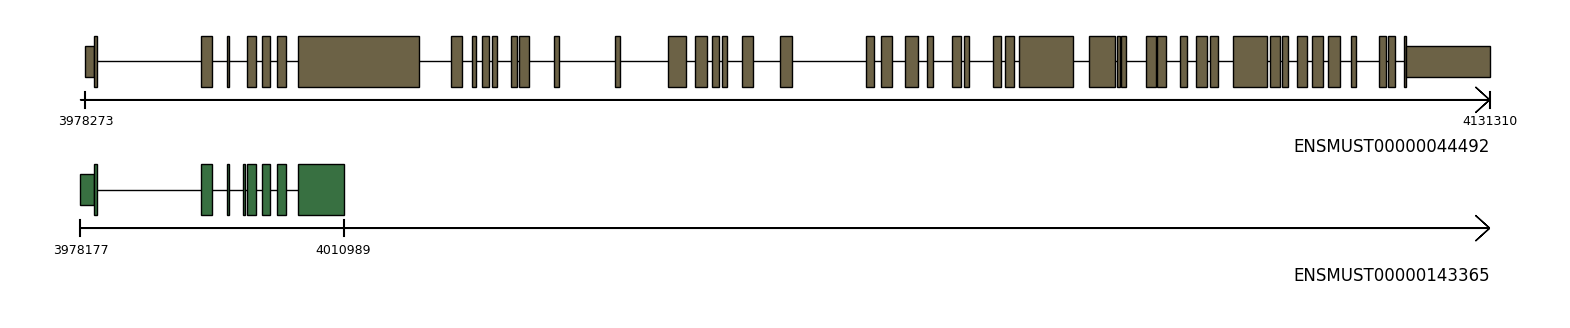

In [12]:
tp.draw_transcripts_list(['ENSMUST00000044492', 'ENSMUST00000143365'], colors=ghibli, draw_cds=True)


In [13]:
#

get_transcript_info helps to retrieve information about the transcripts of interest:

In [14]:
import pandas as pd  

transcripts = ["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"]
transcripts_info = []

for i in transcripts:
    transcripts_info.append(tp.get_transcript_info(i))  # Append transcript info to list

df = pd.DataFrame(transcripts_info)  # Convert list of dictionaries to DataFrame
print(df)  # Display the DataFrame

        transcript_id transcript_name transcript_type  cds_start   cds_end  \
0  ENSMUST00000107851        Clta-205         unknown   44012791  44032569   
1  ENSMUST00000107846        Clta-202         unknown   44012791  44032569   
2  ENSMUST00000107847        Clta-203         unknown   44012791  44032569   

  chromosome strand  
0          4      +  
1          4      +  
2          4      +  


"draw_transcript_list_unscaled" keeps the structure of transcripts but shortens the introns. It is useful to compare the structure of
transcipts with extremely long introns:

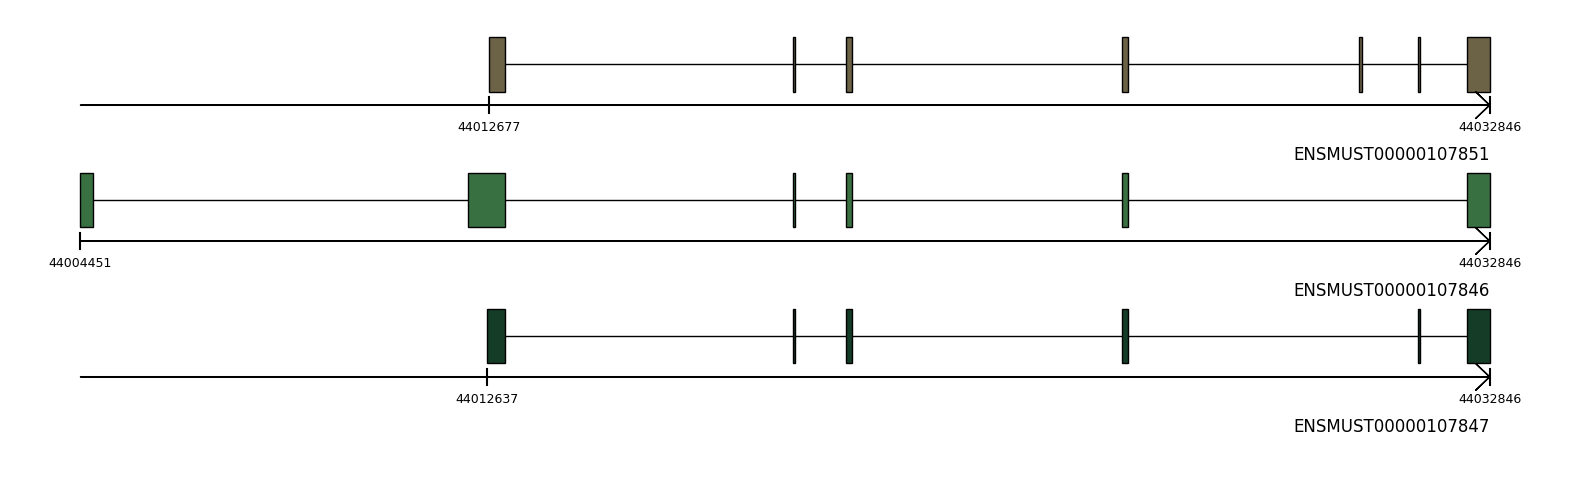

In [15]:
tp.draw_transcripts_list_unscaled(["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"], colors=ghibli)

If neither gtf nor fasta is provided, the transcripts can be provided as ensembl id and the coordinates will be fetched from ensembl api.

In [16]:
#cage_peaks = "https://fantom.gsc.riken.jp/5/datafiles/reprocessed/mm10_latest/extra/CAGE_peaks/mm10_fair+new_CAGE_peaks_phase1and2.bed.gz"
cage_peaks = "https://reftss.riken.jp/datafiles/current/mouse/refTSS_v4.1_mouse_coordinate.mm39.bed.gz"

In [17]:
def download_and_extract_bed(url, local_folder):
    """
    Downloads and extracts a BED file from a given URL if it doesn't already exist.
    
    Parameters:
    - url (str): The URL of the `.bed.gz` file to download.
    - local_folder (str): The folder where the file should be saved.
    
    Returns:
    - str: Path to the extracted BED file.
    """
    # Ensure local folder exists
    os.makedirs(local_folder, exist_ok=True)

    # Extract filename from URL
    filename = os.path.basename(url)
    compressed_file = os.path.join(local_folder, filename)
    extracted_file = compressed_file.replace(".gz", "")

    # Check if extracted file already exists
    if os.path.exists(extracted_file):
        print(f"Extracted BED file already exists: {extracted_file}")
        return extracted_file

    # Download if necessary
    if not os.path.exists(compressed_file):
        print(f"Downloading {compressed_file}...")
        response = requests.get(url, stream=True)
        with open(compressed_file, "wb") as f:
            shutil.copyfileobj(response.raw, f)
        print("Download complete.")

    # Extract the file
    print(f"Extracting {compressed_file}...")
    with gzip.open(compressed_file, "rb") as f_in, open(extracted_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"Extraction complete: {extracted_file}")

    return extracted_file

In [18]:
cage_peaks = download_and_extract_bed(cage_peaks, "../data/")

Extracted BED file already exists: ../data/refTSS_v4.1_mouse_coordinate.mm39.bed


In [19]:
import pandas as pd
#col_names = ["chrom", "start", "end", "name", "score", "strand"]
cage_df = pd.read_csv(cage_peaks, sep="\t", comment='#')

In [20]:
cage_df

,chromosome,start,end,refTSS_ID,score,strand
0,chr1,3221101,3221109,rfmm_1.1,1,+
1,chr1,3226272,3226277,rfmm_2.1,1,+
2,chr1,3389727,3389730,rfmm_3.1,1,-
3,chr1,3448009,3448012,rfmm_4.1,1,-
4,chr1,3559372,3559376,rfmm_5.1,1,-
...,...,...,...,...,...,...
172319,chrY,90831164,90831167,rfmm_172320.1,1,+
172320,chrY,90831173,90831188,rfmm_172321.1,1,+
172321,chrY,90831968,90831970,rfmm_172322.1,1,+
172322,chrY,90836575,90836577,rfmm_172323.1,1,-


In [21]:
# find the tss that overlap with the gene coordinates:
# get the coordinates of plot transcript panel, find the tss coordinates 
# that are inside these limits (pos_end, pos_start in _draw_transcript):


In [22]:
def extract_genes_from_gtf(gtf_gz_path, output_gtf, gene_ids):
    """
    Extracts specified genes from a GTF file inside a .gz archive and writes a new GTF file.

    Parameters:
    - gtf_gz_path (str): Path to the original GTF .gz file.
    - output_gtf (str): Path for the new GTF file.
    - gene_ids (list): List of gene IDs to extract (e.g., ["ENSMUSG00000025902", "ENSMUSG00000025903"]).
    """
    extracted_gtf_path = gtf_gz_path.rstrip(".gz")  # Remove .gz extension for the extracted file

    # Check if extracted file already exists
    from pathlib import Path
    if not Path(extracted_gtf_path).exists():
        print(f"🔄 Extracting {gtf_gz_path}...")
        with gzip.open(gtf_gz_path, "rt") as gz_file, open(extracted_gtf_path, "w") as out_file:
            shutil.copyfileobj(gz_file, out_file)
        print(f"✅ Extracted: {extracted_gtf_path}")
    else:
        print(f"📂 Using existing extracted file: {extracted_gtf_path}")

    # Read the extracted GTF file, skipping comment lines
    gtf = pd.read_csv(extracted_gtf_path, sep="\t", comment='#', header=None, dtype=str)

    # GTF column names based on Ensembl/Gencode format
    gtf.columns = [
        "seqname", "source", "feature", "start", "end", "score",
        "strand", "frame", "attribute"
    ]

    # Extract gene IDs from the 'attribute' column
    def get_gene_id(attribute):
        for entry in attribute.split(";"):
            entry = entry.strip()
            if entry.startswith("gene_id"):
                return entry.split(" ")[1].strip('"')
        return None

    # Filter GTF for the selected genes
    gtf["gene_id"] = gtf["attribute"].apply(get_gene_id)
    filtered_gtf = gtf[gtf["gene_id"].isin(gene_ids)].drop(columns=["gene_id"])

    # Save to new GTF file
    filtered_gtf.to_csv(output_gtf, sep="\t", index=False, header=False, quoting=3)

    print(f"✅ Extracted {len(filtered_gtf)} entries for {len(gene_ids)} genes into {output_gtf}")


In [23]:
# big_gtf = "/data/analysis/data_diamant/allos/allos/data/Mus_musculus.GRCm39.109.gtf"
# custom_gtf = "/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf"
# selected_genes = ["ENSMUSG00000028478", "ENSMUSG00000025903"]  # Replace with your genes of interest

# extract_genes_from_gtf(big_gtf, custom_gtf, selected_genes)


📂 Using existing extracted file: /data/analysis/data_diamant/allos/allos/data/Mus_musculus.GRCm39.109.gtf


PermissionError: [Errno 13] Permission denied: '/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf'

In [119]:
# from allos.transcript_data import TranscriptData
# td = TranscriptData(gtf_file="/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf")

In [121]:
# td

In [122]:
# td.get_exon_coords_and_strand("ENSMUSG00000028478")

([], None)

In [150]:
# import pyranges as pr

# def get_gene_coordinates_from_gtf(gtf_path, transcript_id):
#     """Extracts chromosome, start, and end coordinates of a gene from a GTF file using transcript ID."""
    
#     # Load GTF file as pyranges object
#     gtf = pr.read_gtf(gtf_path)
    
#     # Check available columns
#     print("Available columns in GTF:", gtf.columns)

#     # Ensure the transcript ID column exists
#     if "transcript_id" not in gtf.columns:
#         raise ValueError("Column 'transcript_id' not found in GTF. Check column names.")

#     # Find the gene associated with the given transcript ID
#     transcript_info = gtf[gtf.transcript_id == transcript_id]  # Use the correct column name

#     if transcript_info.empty:
#         raise ValueError(f"Transcript '{transcript_id}' not found in GTF file.")

#     # Get gene ID associated with the transcript
#     gene_id = transcript_info.gene_id.iloc[0]  # Ensure correct column name
    
#     # Extract gene coordinates
#     gene_info = gtf[gtf.gene_id == gene_id]  # Ensure correct column name

#     chromosome = gene_info.Chromosome.iloc[0]
#     start = gene_info.Start.min()
#     end = gene_info.End.max()

#     return {"gene_id": gene_id, "chromosome": chromosome, "start": start, "end": end}


# def find_tss_in_gene_range(cage_peaks_df, gene_coordinates):
#     """Finds CAGE TSS peaks that overlap with the gene coordinates."""
#     # Ensure chromosome formats match between gene_coordinates and cage_peaks_df
#     gene_chr = gene_coordinates["chromosome"]
#     cage_chr = cage_peaks_df["chromosome"].unique()

#     # Check if gene_chr starts with "chr"
#     if not gene_chr.startswith("chr"):
#         gene_coordinates["chromosome"] = f"chr{gene_chr}"

#     # Check if cage_peaks_df chromosomes start with "chr"
#     if any(not c.startswith("chr") for c in cage_chr):
#         cage_peaks_df["chromosome"] = cage_peaks_df["chromosome"].apply(lambda x: f"chr{x}" if not x.startswith("chr") else x)

#     print("✅ Chromosome formats are now consistent!")
#     # Filter peaks that are in the same chromosome
#     peaks_in_chromosome = cage_peaks_df[cage_peaks_df["chromosome"] == gene_coordinates["chromosome"]]

#     # Ensure coordinates are integers
#     gene_start = int(gene_coordinates["start"])
#     gene_end = int(gene_coordinates["end"])

#     peaks_in_chromosome["start"] = peaks_in_chromosome["start"].astype(int)
#     peaks_in_chromosome["end"] = peaks_in_chromosome["end"].astype(int)

#     # Filter peaks that overlap the gene range
#     overlapping_peaks = peaks_in_chromosome[
#         (peaks_in_chromosome["start"] >= gene_coordinates["start"]) &
#         (peaks_in_chromosome["end"] <= gene_coordinates["end"])
#     ]

#     return overlapping_peaks

In [151]:
# # Example Usage
# gtf_path = "/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf"
# transcript_id = "ENSMUST00000134384"
# gene_coordinates = get_gene_coordinates_from_gtf(gtf_path, "ENSMUST00000134384")
# print("Extracted Gene Coordinates:", gene_coordinates)

Available columns in GTF: Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype',
       'transcript_support_level', 'exon_number', 'exon_id', 'exon_version',
       'protein_id', 'protein_version', 'tag', 'ccds_id'],
      dtype='object')
Extracted Gene Coordinates: {'gene_id': 'ENSMUSG00000025903', 'chromosome': '1', 'start': 4878010, 'end': 4918633}


In [152]:
# cage_peaks_path = "/data/analysis/data_diamant/allos/allos/data/refTSS_v4.1_mouse_coordinate.mm39.bed"
# # Load CAGE peaks as a dataframe
# cage_peaks_df = pd.read_csv(cage_peaks_path, sep="\t", names=["chromosome", "start", "end", "refTSS_ID", "score", "strand"])

# # Get gene coordinates from GTF
# gene_coordinates = get_gene_coordinates_from_gtf(gtf_path, transcript_id)


Available columns in GTF: Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype',
       'transcript_support_level', 'exon_number', 'exon_id', 'exon_version',
       'protein_id', 'protein_version', 'tag', 'ccds_id'],
      dtype='object')


/tmp/ipykernel_3974226/2903875487.py:3: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  cage_peaks_df = pd.read_csv(cage_peaks_path, sep="\t", names=["chromosome", "start", "end", "refTSS_ID", "score", "strand"])


In [153]:
# gene_coordinates

{'gene_id': 'ENSMUSG00000025903',
 'chromosome': '1',
 'start': 4878010,
 'end': 4918633}

In [154]:
# find_tss_in_gene_range(cage_peaks_df, gene_coordinates)

✅ Chromosome formats are now consistent!


/tmp/ipykernel_3974226/1431948614.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_in_chromosome["start"] = peaks_in_chromosome["start"].astype(int)
/tmp/ipykernel_3974226/1431948614.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_in_chromosome["end"] = peaks_in_chromosome["end"].astype(int)


,chromosome,start,end,refTSS_ID,score,strand
38,chr1,4878070,4878151,rfmm_38.1,1,+
39,chr1,4878469,4878510,rfmm_39.1,1,+
40,chr1,4898798,4898839,rfmm_40.1,1,+
41,chr1,4915816,4915827,rfmm_41.1,1,+
